In [143]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans

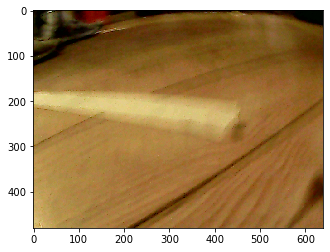

In [283]:
filename = 'data/img_00095.png'

rgb = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)

plt.imshow(rgb)
plt.show()

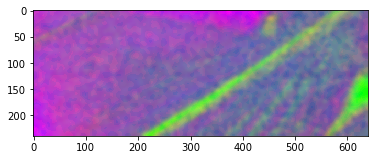

In [284]:
hsv = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2HSV)
hsv = cv2.GaussianBlur(hsv, (21,21), 0)
hsv = hsv[240:,:,:]

mu = np.mean(hsv,axis=(0,1))
std = np.std(hsv,axis=(0,1))

hsv = (hsv - mu) / std

min_ = np.min(hsv, axis=(0,1))
max_ = np.max(hsv, axis=(0,1))

hsv = (hsv - min_) / (max_ - min_ )

plt.imshow(hsv)
plt.show()

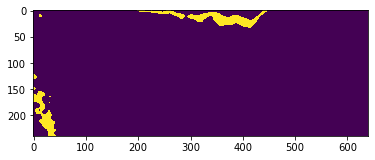

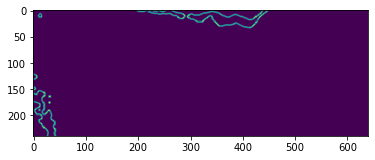

In [285]:
lower_hsv = np.array([0.3, 0.05, 0.70])
upper_hsv = np.array([0.90, 0.2, 0.9])
mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

plt.imshow(mask)

plt.show()

edges = cv2.Canny(mask,200,100)
edges = cv2.GaussianBlur(edges, (5,5), 0)
plt.imshow(edges)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


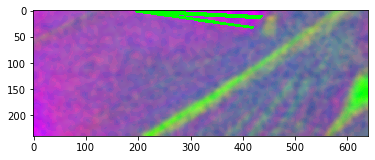

In [286]:
lines = cv2.HoughLinesP(edges,1,np.pi/180,100, minLineLength=100, maxLineGap=100)
if lines is not None:
    
    for line in lines:
        x1,y1,x2,y2 = line[0]        
        hsv = cv2.line(hsv, (x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(hsv)
plt.show()

/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


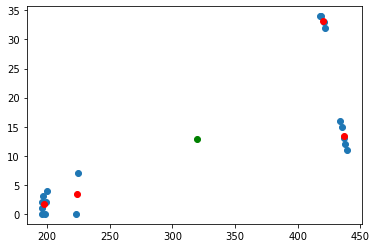

In [287]:

lines = lines.reshape(-1,2)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(lines)

keypoints = np.asarray([kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1]])

lower_mean = [np.mean(keypoints[0, keypoints[1] < 120]),np.mean(keypoints[1, keypoints[1] < 120])]
upper_mean = [np.mean(keypoints[0, keypoints[1] >= 120]),np.mean(keypoints[1, keypoints[1] >= 120])]

plt.plot(lines[:,0], lines[:,1], 'o')
plt.plot(keypoints[0,:], keypoints[1,:], 'o',c='red')
plt.plot(lower_mean[0], lower_mean[1], 'o',c='green')
plt.plot(upper_mean[0], upper_mean[1], 'o',c='green')
plt.show()


array([ True,  True])

In [288]:
rgb = cv2.line(rgb, (int(lower_mean[0]),int(lower_mean[1])+240),(int(upper_mean[0]),int(upper_mean[1])+240),(0,255,0),2)
plt.imshow(rgb)
plt.show()

ValueError: cannot convert float NaN to integer

# Make video

In [299]:
def pipeline(filename):
    
    # load images
    rgb = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2HSV)
    
    # Gaussain blur 
    hsv = cv2.GaussianBlur(hsv, (21,21), 0)
    
    # only look at buttom half
    hsv = hsv[240:,:,:]

    # standardize each color channel
    mu = np.mean(hsv,axis=(0,1))
    std = np.std(hsv,axis=(0,1))
    hsv = (hsv - mu) / std

    # normalize each color channel
    min_ = np.min(hsv, axis=(0,1))
    max_ = np.max(hsv, axis=(0,1))
    hsv = (hsv - min_) / (max_ - min_ )

    # threshold images
    lower_hsv = np.array([0.3, 0.05, 0.70])
    upper_hsv = np.array([0.90, 0.2, 0.9])
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)

    # find edges
    edges = cv2.Canny(mask,200,100)
    edges = cv2.GaussianBlur(edges, (5,5), 0)

    # find lines
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100, minLineLength=100, maxLineGap=100)

    if lines is None:
        return None
    
    # visualize lines on top of hsv
    hsv_lines = hsv.copy()
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line[0]        
            hsv_lines = cv2.line(hsv_lines, (x1,y1),(x2,y2),(0,255,0),2)

    # find kmeans clusters
    lines = lines.reshape(-1,2)
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(lines)
    
    keypoints = np.asarray([kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1]])
    
    # find upper and lower key points for center line
    lower_mean = [np.mean(keypoints[0, keypoints[1] < 120]),np.mean(keypoints[1, keypoints[1] < 120])]
    upper_mean = [np.mean(keypoints[0, keypoints[1] >= 120]),np.mean(keypoints[1, keypoints[1] >= 120])]
    
    if np.isnan(upper_mean).any() or np.isnan(lower_mean).any(): 
        return None
    
    # visualize line on top of original image
    rgb = cv2.line(rgb, (int(lower_mean[0]),int(lower_mean[1])+240),(int(upper_mean[0]),int(upper_mean[1])+240),(0,255,0),2)
    
    return rgb, [lines, keypoints, lower_mean, upper_mean], hsv_lines, hsv, mask, edges

In [378]:
def visualize_pipeline(rgb, hsv_lines, hsv, mask, edges):

    mask = mask.astype(float) / 255.0
    
    img0 = rgb / 255.0
    img1 = np.concatenate([hsv_lines, hsv])    
    img2 = cv2.cvtColor(np.concatenate([mask.astype(np.uint8), edges.astype(np.uint8)]), cv2.COLOR_GRAY2RGB)

    img = np.concatenate([img0, img1, img2], axis=1) * 255

    return img.astype(np.uint8)

In [379]:
img_array = []
basepath = 'data'
for i, filename in enumerate(sorted(os.listdir(basepath))):

    filename = os.path.join(basepath, filename)
    
    out = pipeline(filename)
    
    if out is not None:
        rgb, [lines, keypoints, lower_mean, upper_mean], hsv_lines, hsv, mask, edges = out
        img = visualize_pipeline(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), hsv_lines, hsv, mask, edges)
        img_array.append(img)

height, width, layers = img_array[0].shape
size = (width,height)

/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/frederikwarburg/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.ty

In [381]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('video3.mp4', fourcc, 1, (width, height))
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()